# Reconhecimento de dígitos utilizando a arquitetura LeNet-5 com o conjunto de dados MNIST

Esse projeto possui o objetivo de utilizar a biblioteca Keras para desenvolver um modelo de rede neural convolucional para identificar padrões na base de dados MNIST, que consiste em 60000 imagens de dígitos escritos à mão. 

Primeiramente serão feitas uma análise do dataset, uma exploração do conjunto de dados e a preparação do modelo, para posterior validação e teste.

O modelo convolucional estudado se trata da arquitetura clássica LeNet-5. 


## Dataset

Primeiramente, precisamos acessar o dataset que será utilizado para treinar e testar a nossa rede neural convolucional. O conjunto de dados foi retirado do site oficial do criador dessa arquitetura, [Yann LeCun](http://yann.lecun.com/exdb/mnist/). O dataset consiste em:

* train-images-idx3-ubyte.gz:  imagens de treino
* train-labels-idx1-ubyte.gz:  labels para as imagens de treino 
* t10k-images-idx3-ubyte.gz:   imagens de teste
* t10k-labels-idx1-ubyte.gz:   labels para as imagens de teste

Vamos criar uma função para baixar o conjunto de dados:

In [1]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [2]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

Agora vamos carregar os dados de teste e treino na memória.

In [3]:
#Bibliotecas auxiliares para leitura 
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
def read_gzip(images_path: str, labels_path: str):
    #lendo as labels
    with gzip.open(labels_path, 'rb') as labels:
        labels = np.frombuffer(labels.read(), dtype=np.uint8, offset=8)

    #lendo as features
    with gzip.open(images_path,'rb') as images:
        length = len(labels)
        #Primeiramente carregamos as imagens que estão "esticadas" em um vetor 
        #de 784 números (imagens com 28x28 pixels) e as convertemos em 28x28x1
        features = np.frombuffer(images.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [5]:
#train e test serão dicionários que guardarão as features e os labels das imagens
train = {}
test = {}

train['features'], train['labels'] = read_gzip('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_gzip('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

Vamos agora verificar o número de imagens nos training e test sets.

In [6]:
print('# de imagens de treino:', train['features'].shape[0])
print('# de imagens de teste:', test['features'].shape[0])

# de imagens de treino: 60000
# de imagens de teste: 10000


## Explorando o conjunto de dados

#### Agora vamos criar uma função para olhar algumas imagens do dataset.

In [7]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

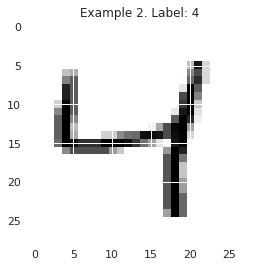

In [8]:
display_image(2)

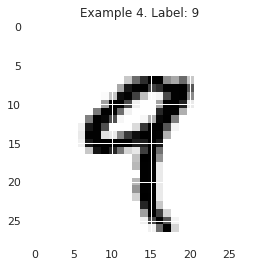

In [9]:
display_image(4)

#### Verificando se o conjunto de dados está balanceado, ou seja, se existem quantidades parecidas de dados para cada label. 

In [10]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


#### Vamos agora dividir o conjunto de dados de treinamento em dados para treinamento e dados para validação. 

O Training set é o conjunto de dados que é utilizado de fato para treinamento, e serve para encontrarmos pesos (idealmente ótimos) utilizando a técnica de back-propagation.

Já o Validation set é utilizado para tunar os parâmetros da rede, como número de hidden units, ou determinar um ponto de parada para o algoritmo de back-propagation. Ao "tunarmos" os parâmetros da rede utilizando o Validation set, adicionamos um viés a esse conjunto de dados, logo ele não serve para testar a real performance do nosso modelo, assim precisamos do Test set. 

O ideal é não modificar a rede utilizando como base o Test set, pois como explicado anteriormente, adicionaremos um viés ao conjunto de dados e as métricas de desempenho não representarão o real desempenho do modelo. 

Dividiremos o Training set anterior então em 80% dos dados para o novo Training set e 20% dos dados para o Validation set. 

In [11]:
#Separando o Training set em Training e Validation set
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [12]:
print('# de imagens de treinamento:', train['features'].shape[0])
print('# de imagens de validação:', validation['features'].shape[0])

# de imagens de treinamento: 48000
# de imagens de validação: 12000


## Preparando as features

A arquitetura LeNet-5 utiliza como entrada imagens de 32x32 pixels. Como temos imagens com 28x28 pixels, precisamos fazer a técnica *zero padding*, adicionando 2 pixels em cada lado da imagem. 

In [13]:
#Realizando a técnica de zero padding no conjunto de dados
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


## Implementação da arquitetura LeNet-5



A arquitetura a ser implementada consiste nos seguintes layers:

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)

#### Architecture
* **Convolutional Layer #1** resulta em uma saída com dimensões 28x28x6.
    * **Ativação** utilizaremos uma relu

* **Pooling Layer #1** resulta em uma saída com dimensões 14x14x6.

* **Convolutional Layer #2** resulta em uma saída com dimensões 10x10x16.
    * **Ativação** utilizaremos uma relu

* **Pooling Layer #2** resulta em uma saída com dimensões 5x5x16.
    * **Flatten** "planariza" a dimensão da saída

* **Fully Connected Layer #1** resulta em uma saída com dimensões 120x1.
    * **Ativação** utilizaremos uma relu

* **Fully Connected Layer #2** resulta em uma saída com dimensões 84x1.
    * **Ativação** utilizaremos uma relu

* **Fully Connected (Logits) #3** resulta em uma saída de dimensão 10, sendo as probabilidades das imagens serem números de 0 a 9. 

In [14]:
#Definindo a arquitetura do modelo
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [16]:
#Definindo qual será a função de loss, o otimizador e a métrica a ser otimizada
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [17]:
#Definindo o número de épocas que o modelo vai executar e o tamanho do lote 
#dos dados
EPOCHS = 10
BATCH_SIZE = 128

In [22]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])
X_test, y_test = test['features'], to_categorical(test['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [20]:

print('# de imagens de treinamento:', train['features'].shape[0])
print('# de imagens de validação:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# de imagens de treinamento: 48000
# de imagens de validação: 12000
Epoch 1/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.0585 - val_accuracy: 0.9856
Epoch 2/10
375/375 [==============================] - 24s 63ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 0.0565 - val_accuracy: 0.9868
Epoch 3/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.0554 - val_accuracy: 0.9881
Epoch 4/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.0555 - val_accuracy: 0.9878
Epoch 5/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0522 - val_accuracy: 0.9862
Epoch 6/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.0534 - val_accuracy: 0.9853
Epoch 7/10
375/375 [==============================] - 23s 61ms/step 

Como pode ser conferido, a rede obteve uma acurácia de 99.82% na validação após 10 épocas de treinamento. É um resultado bem expressivo. Agora vamos avaliar o modelo no Test set. 

In [25]:
_, accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.0682 - accuracy: 0.9860


No Test set a nossa acurácia foi de 98.6%, também representando um ótimo desempenho. 

In [58]:
import pandas as pd

#Salvando as saídas da rede para o Test set
Y_pred = model.predict(X_test)

#Transformando o array em um array unidimensional
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)


y_actu = pd.Series(Y_true, name='Actual')
y_pred = pd.Series(Y_pred_classes, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

print(df_confusion)

Predicted    0     1     2     3    4    5    6     7    8     9
Actual                                                          
0          966     0     1     0    2    0    4     3    0     4
1            0  1129     2     3    0    0    0     1    0     0
2            0     0  1017     2    0    0    0    12    0     1
3            0     0     1  1003    0    1    0     4    1     0
4            0     0     0     0  971    0    0     0    0    11
5            2     0     0    14    0  863    4     1    1     7
6            3     2     0     0    1    1  950     0    1     0
7            0     1     2     0    0    0    0  1023    0     2
8            1     1     5     6    1    0    3     8  938    11
9            0     1     0     1    4    0    0     2    1  1000


Como pode ser conferido pela Confusion Matrix acima, os erros comuns cometidos pela rede são:

* Classificar 3 quando na realidade o número é 5 (ocorrência: 14)
* Classificar 7 quando na realidade o número é 2 (ocorrência: 12)
* Classificar 9 quando na realidade o número é 8 (ocorrência: 11)
* Classificar 9 quando na realidade o número é 4 (ocorrência: 11)

Além desses erros não foram identificandas fontes de erro muito relevantes, e no geral o modelo desempenhou um bom papel na classificação dos dígitos.